In [1]:
import sys
import time
import common
import argparse
import datasets
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import tensorflow as tf
import tensorflow_lattice as tfl
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'


def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)
    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng,
                                                  dataset)
    sel = cal_true_card(
        (cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset):
    vals = []
    new_table = table.data
    s = new_table.iloc[rng.randint(0, new_table.shape[0])]
    vals = s.values

    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)
    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    #ops = rng.choice(['='], size=num_filters)
    ops = rng.choice(['<=', '>=', '>', '<'], size=num_filters)
    #ops = rng.choice(['<=', '>='], size=num_filters)
    #ops = rng.choice(['<='], size=num_filters)
    #ops_all_eqs = ['='] * num_filters
    #sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #ops = np.where(sensible_to_do_range, ops, ops_all_eqs)
    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals
    vals = vals[idxs]
    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])
    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values


def dictionary_column_interval(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        column_interval[k] = sorted(list(v))
        least, great = column_interval[k][0], column_interval[k][-1]
        column_interval[k] = sorted([0, least/2] + column_interval[k] + [great+1])
    return column_interval


def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]


def seperate_train_test(train_size, unique_intervals, query_set):
    X, Y = [], []
    origin = np.array([[0, v[-1]] for v in unique_intervals.values()]).ravel()
    for query in query_set:
        x = list(origin)
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            if ops[i][0] == "<=":
                x[col_idxs[i]*2+1] = vals[i][0]
            elif ops[i][0] == "<":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2+1] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == ">":
                x[col_idxs[i]*2] = vals[i][0]
            elif ops[i][0] == ">=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) + 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == "=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
                x[col_idxs[i]*2+1] = vals[i][0]
        X.append(x)
        Y.append(sel)
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32).reshape(-1, 1)
    total = np.concatenate((X, Y), axis=1)
    #total = np.unique(total, axis=0)
    choose = np.random.choice(total.shape[0], size=round(total.shape[0]*train_size), replace=False)
    others = list(set(range(total.shape[0])) - set(choose))
    train, test = total[choose], total[others]

    df_train = pd.DataFrame(train, columns=[f'col_{i}' for i in range(total.shape[1])])
    new_train = np.array(df_train.sort_values(by=list(df_train.columns)[:-1]))
    train_X, train_Y = np.hsplit(new_train, [-1])

    df_test = pd.DataFrame(test, columns=[f'col_{i}' for i in range(total.shape[1])])
    new_test = np.array(df_test.sort_values(by=list(df_test.columns)[:-1]))
    test_X, test_Y = np.hsplit(new_test, [-1])
    return train_X, train_Y, test_X, test_Y


class LatticeCDF:
    def __init__(
            self,
            name,
            n_row,
            unique_intervals,
            pwl_keypoints=None,  # also can input table unique values
            lattice_size=2):

        self.model_path = './models/Lattice/model/' + name
        self.weight_path = './models/Lattice/weight/' + name
        self.n_row = n_row
        self.dim = len(unique_intervals.keys())
        self.lattice_size = lattice_size
        self.unique_intervals = unique_intervals
        self.pwl_calibration_input_keypoints = unique_intervals if pwl_keypoints is None else pwl_keypoints

        self.model_inputs = []
        for i in range(self.dim):
#             self.model_inputs.append(
#                 tf.keras.layers.Input(shape=[1], name='col_%s' % i))
            self.model_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col%s_l' % i))
            self.model_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col%s_u' % i))

        self.calibrators = []
        for i in range(self.dim):
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(
                        self.pwl_calibration_input_keypoints[i]),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='decreasing',
                ))
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(
                        self.pwl_calibration_input_keypoints[i]),
                    # input_keypoints=np.linspace(
                    #     feat_mins[i],
                    #     feat_maxs[i],
                    #     num=pwl_calibration_num_keypoints),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                ))

        self.lattice_inputs = []
        for i in range(self.dim * 2):  # (self.dim) * 2):
            self.lattice_inputs.append(self.calibrators[i](
                self.model_inputs[i]))

        self.lattice = tfl.layers.Lattice(
            lattice_sizes=[lattice_size] * self.dim * 2,  # (self.dim * 2),
            #lattice_sizes=[len(v) for v in self.unique_intervals.values()],
            interpolation='hypercube',  # 可以尝试别的插值类型
            monotonicities=['increasing'] * self.dim * 2,  # (self.dim * 2),
            output_min= 0.0,
            output_max= 1.0,
            name='lattice',
        )
        
        self.model_output = self.lattice(self.lattice_inputs)

        self.model = tf.keras.models.Model(
            inputs=self.model_inputs,
            outputs= self.model_output
        )
        self.model.save('%s.hdf5' % self.model_path)
        self.model.summary()


    def fit(self,
            X,
            y,
            lr=0.01,
            bs=16,
            epochs=3000,
            reduceLR_factor=0.5,
            reduceLR_patience=20,
            verbose=1,
            loss='MSE',
            opt='Adam'):
        assert X.shape[0] == y.shape[0]

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        features = [X[:, i] for i in range(X.shape[1])]
        target = y

        Loss = {
            'MAE': tf.keras.losses.mean_absolute_error,
            'MSE': tf.keras.losses.mean_squared_error,
            'MAPE': tf.keras.losses.mean_absolute_percentage_error
        }

        Opt = {
            'Adam': tf.keras.optimizers.Adam(),
            'Nadam': tf.keras.optimizers.Nadam(),
            'Adagrad': tf.keras.optimizers.Adagrad(),
            'Adadelta': tf.keras.optimizers.Adadelta(),
            'Adamax': tf.keras.optimizers.Adamax(),
            'RMSprop': tf.keras.optimizers.RMSprop(),
        }
        self.model.compile(loss=Loss[loss], optimizer=Opt[opt])

        earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                         patience=500,
                                                         verbose=verbose,
                                                         mode='min')
        mcp_save = tf.keras.callbacks.ModelCheckpoint('%s.hdf5' %
                                                      self.weight_path,
                                                      save_best_only=True,
                                                      monitor='loss',
                                                      mode='min',
                                                      save_weights_only=True)
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            epsilon=1e-10,
            mode='min')

        self.model.fit(features,
                       target,
                       epochs=epochs,
                       batch_size=bs,
                       verbose=1,
                       callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
        self.model.load_weights('%s.hdf5' % self.weight_path)

    def load(self):
        self.model = tf.keras.models.load_model('%s.hdf5' % self.model_path)
        self.model.load_weights('%s.hdf5' % self.weight_path)

    def inference(self, grid):
        assert grid.shape[1] == self.dim * 2
#         length = grid.shape[0]
#         grid_dict = {}
#         for i in range(grid.shape[1]):
#             grid_dict[f'col_{i}_l'] = [0] * length
#             grid_dict[f'col_{i}_u'] = grid[:, i]
#         extend_grid = np.array(pd.DataFrame(grid_dict))
#         pred = m.model.predict(np.hsplit(extend_grid, self.dim * 2))
        pred = m.model.predict(np.hsplit(grid, self.dim * 2))
        return pred

In [2]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset',
                        type=str,
                        default='wine1',
                        help='Dataset.')
    parser.add_argument('--loss', type=str, default='MSE', help='Loss.')
    parser.add_argument('--opt', type=str, default='Adam', help='Optimizer.')
    parser.add_argument('--query-size',
                        type=int,
                        default=3000,
                        help='query size')
    parser.add_argument('--train-size',
                        type=float,
                        default=0.8,
                        help='train size')
    parser.add_argument('--num-conditions',
                        type=int,
                        default=1,
                        help='num of conditions')
    parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
    parser.add_argument('--bs', type=int, default=1000, help='Batch size.')
    parser.add_argument('--lattice', type=int, default=2, help='Lattice size.')
    parser.add_argument('--seed', type=int, default=4321, help='Random seed')
    parser.add_argument('--sample',
                        type=int,
                        default=0,
                        help='reload trained mode')
    parser.add_argument('--epochs',
                        type=int,
                        default=2000,
                        help='Number of epochs to train for.')
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    bs = int(args.bs)
    lr = float(args.lr)
    train_size = float(args.train_size)
    epochs = int(args.epochs)
    lattice = int(args.lattice)
    sample = int(args.sample)

    type_casts = {}
    table = datasets.LoadDataset(args.dataset + '.csv',
                                 args.dataset,
                                 type_casts=type_casts)
    print('Begin Generating Queries ...')
    time0 = time.time()
    rng = np.random.RandomState(args.seed)
    query_set = [
        GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset)
        for i in trange(args.query_size)
    ]
    print('Complete Generating Queries.')

    # Lattice
    print("\n\nBuilding Lattice...")
    time1 = time.time()
    table_size = table.data.shape
    n_row, n_column = table_size[0], table_size[1]
    unique_intervals = dictionary_column_interval(table_size, query_set)
    column_interval_number = count_column_unique_interval(unique_intervals)
    train_X, train_Y, test_X, test_Y = seperate_train_test(train_size, unique_intervals, query_set)
    print("train set:", train_X.shape[0])
    print("test set:", test_X.shape[0])
    name = f"{args.dataset}_{args.query_size}query_{args.num_conditions}column_{args.epochs}epoch"
    m = LatticeCDF(name, n_row, unique_intervals, pwl_keypoints=None)
    
    print("\n\nLattice is already built, begin training...\n")
    time2 = time.time()
    m.fit(train_X,
          train_Y,
          lr=lr,
          bs=bs,
          epochs=epochs,
          loss=args.loss,
          opt=args.opt
         )

load dataset wine1.csv done
(6497, 1)
(6497, 1)
0
0 106
Begin Generating Queries ...



Complete Generating Queries.


Building Lattice...
train set: 2400
test set: 600
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
col0_l (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
col0_u (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
pwl_calibration (PWLCalibration (None, 1)            92          col0_l[0][0]                     
__________________________________________________________________________________________________
pwl_calibration_1 (PWLCalibrati (None, 1)            92          col0_u[0][0]                     
____________

2400/2400 [==============================] - 0s 5us/sample - loss: 0.0040
Epoch 166/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0039
Epoch 167/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0039
Epoch 168/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0038
Epoch 169/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0037
Epoch 170/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0036
Epoch 171/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0035
Epoch 172/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0034
Epoch 173/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0033
Epoch 174/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0031
Epoch 175/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 0.0030
Epoch 176/2000
2400/2400 [==========

2400/2400 [==============================] - 0s 5us/sample - loss: 8.1093e-04
Epoch 257/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 8.0618e-04
Epoch 258/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 8.0174e-04
Epoch 259/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.9726e-04
Epoch 260/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.9345e-04
Epoch 261/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.9010e-04
Epoch 262/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.8571e-04
Epoch 263/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.8199e-04
Epoch 264/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.7812e-04
Epoch 265/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.7427e-04
Epoch 266/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 7.7

2400/2400 [==============================] - 0s 5us/sample - loss: 5.5621e-04
Epoch 433/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.5631e-04
Epoch 434/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5565e-04
Epoch 435/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5484e-04
Epoch 436/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5481e-04
Epoch 437/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5403e-04
Epoch 438/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5382e-04
Epoch 439/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5329e-04
Epoch 440/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5304e-04
Epoch 441/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5282e-04
Epoch 442/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.5

2400/2400 [==============================] - 0s 3us/sample - loss: 5.2241e-04
Epoch 609/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.2228e-04
Epoch 610/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.2202e-04
Epoch 611/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.2190e-04
Epoch 612/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.2173e-04
Epoch 613/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.2189e-04
Epoch 614/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.2148e-04
Epoch 615/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.2174e-04
Epoch 616/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.2261e-04
Epoch 617/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.2126e-04
Epoch 618/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.2

2400/2400 [==============================] - 0s 3us/sample - loss: 5.1182e-04
Epoch 785/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.1210e-04
Epoch 786/2000
2400/2400 [==============================] - 0s 2us/sample - loss: 5.1121e-04
Epoch 787/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.1230e-04
Epoch 788/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.1313e-04
Epoch 789/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.1093e-04
Epoch 790/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.1175e-04
Epoch 791/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.1091e-04
Epoch 792/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.1202e-04
Epoch 793/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.1137e-04
Epoch 794/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.1

2400/2400 [==============================] - 0s 3us/sample - loss: 5.0651e-04
Epoch 961/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0688e-04
Epoch 962/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0664e-04
Epoch 963/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0603e-04
Epoch 964/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0625e-04
Epoch 965/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0648e-04
Epoch 966/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0694e-04
Epoch 967/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0628e-04
Epoch 968/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0598e-04
Epoch 969/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.0574e-04
Epoch 970/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0

2400/2400 [==============================] - 0s 3us/sample - loss: 5.0504e-04
Epoch 1047/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0608e-04
Epoch 1048/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0468e-04
Epoch 1049/2000
1000/2400 [===========>..................] - ETA: 0s - loss: 5.0998e-04
Epoch 01049: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0481e-04
Epoch 1050/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0455e-04
Epoch 1051/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0439e-04
Epoch 1052/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0440e-04
Epoch 1053/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.0427e-04
Epoch 1054/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0440e-04
Epoch 1055/2000
24

2400/2400 [==============================] - 0s 3us/sample - loss: 5.0414e-04
Epoch 1131/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0414e-04
Epoch 1132/2000
2400/2400 [==============================] - 0s 5us/sample - loss: 5.0390e-04
Epoch 1133/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0391e-04
Epoch 1134/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0410e-04
Epoch 1135/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0438e-04
Epoch 1136/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0418e-04
Epoch 1137/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0410e-04
Epoch 1138/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0394e-04
Epoch 1139/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0436e-04
Epoch 1140/2000
2400/2400 [==============================] - 0s 3us/sample -

2400/2400 [==============================] - 0s 3us/sample - loss: 5.0390e-04
Epoch 1303/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0373e-04
Epoch 1304/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0388e-04
Epoch 1305/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0351e-04
Epoch 1306/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0355e-04
Epoch 1307/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0354e-04
Epoch 1308/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0353e-04
Epoch 1309/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0357e-04
Epoch 1310/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0374e-04
Epoch 1311/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0360e-04
Epoch 1312/2000
2400/2400 [==============================] - 0s 3us/sample -

2400/2400 [==============================] - 0s 3us/sample - loss: 5.0345e-04
Epoch 1387/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0344e-04
Epoch 1388/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0343e-04
Epoch 1389/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0346e-04
Epoch 1390/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0344e-04
Epoch 1391/2000
1000/2400 [===========>..................] - ETA: 0s - loss: 5.3014e-04
Epoch 01391: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0350e-04
Epoch 1392/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0348e-04
Epoch 1393/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0346e-04
Epoch 1394/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0345e-04
Epoch 1395/2000
24

2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1547/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1548/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1549/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1550/2000
2400/2400 [==============================] - 0s 2us/sample - loss: 5.0342e-04
Epoch 1551/2000
1000/2400 [===========>..................] - ETA: 0s - loss: 5.2458e-04
Epoch 01551: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1552/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1553/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1554/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1555/2000
24

2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1707/2000
2400/2400 [==============================] - 0s 2us/sample - loss: 5.0342e-04
Epoch 1708/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1709/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1710/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1711/2000
1000/2400 [===========>..................] - ETA: 0s - loss: 5.0027e-04
Epoch 01711: ReduceLROnPlateau reducing learning rate to 1.1920929521291868e-10.
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1712/2000
2400/2400 [==============================] - 0s 3us/sample - loss: 5.0342e-04
Epoch 1713/2000
2400/2400 [==============================] - 0s 2us/sample - loss: 5.0342e-04
Epoch 1714/2000
2400/2400 [==============================] - 0s 2us/sample - loss: 5.0342e-04
Epoch 1715/2000
2

In [3]:
values = [v for v in unique_intervals.values()] * 2
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)

In [4]:
grid

array([[ 0. ,  0. ],
       [ 0. ,  2.3],
       [ 0. ,  4.6],
       ...,
       [16.9, 15.6],
       [16.9, 15.9],
       [16.9, 16.9]], dtype=float32)

In [5]:
m.inference(np.array([[0,0]]))

array([[0.01922894]], dtype=float32)

In [6]:
m.inference(np.array([[0,14.7]]))

array([[0.99593234]], dtype=float32)

In [7]:
m.inference(np.array([[2,14.7]]))

array([[0.99590474]], dtype=float32)

In [8]:
train_X

array([[ 0. ,  4.7],
       [ 0. ,  4.8],
       [ 0. ,  4.9],
       ...,
       [13.4, 16.9],
       [13.4, 16.9],
       [13.7, 16.9]], dtype=float32)

In [9]:
train_Y

array([[0.00246268],
       [0.00384793],
       [0.00507927],
       ...,
       [0.00277051],
       [0.00277051],
       [0.00230876]], dtype=float32)

In [10]:
pred = m.inference(grid)
#m.plotting(grid, pred)

In [11]:
# 增加边界点，看看对比的效果
# 增加epoch，看看误差和图形效果
# 增加query size，看看误差和效果

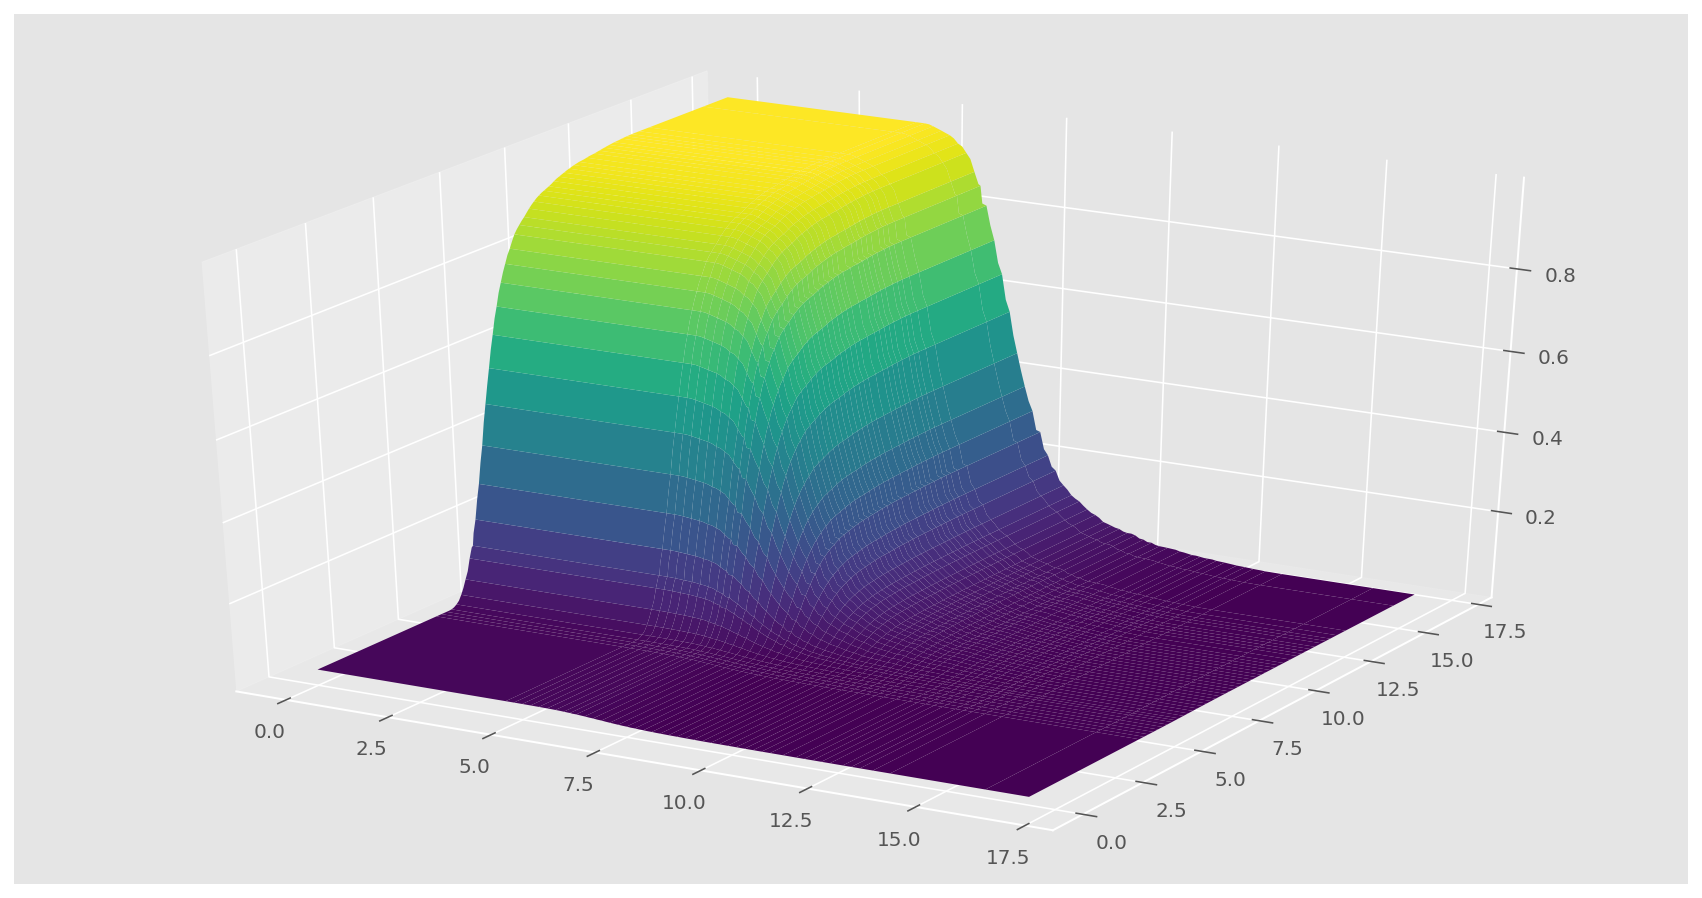

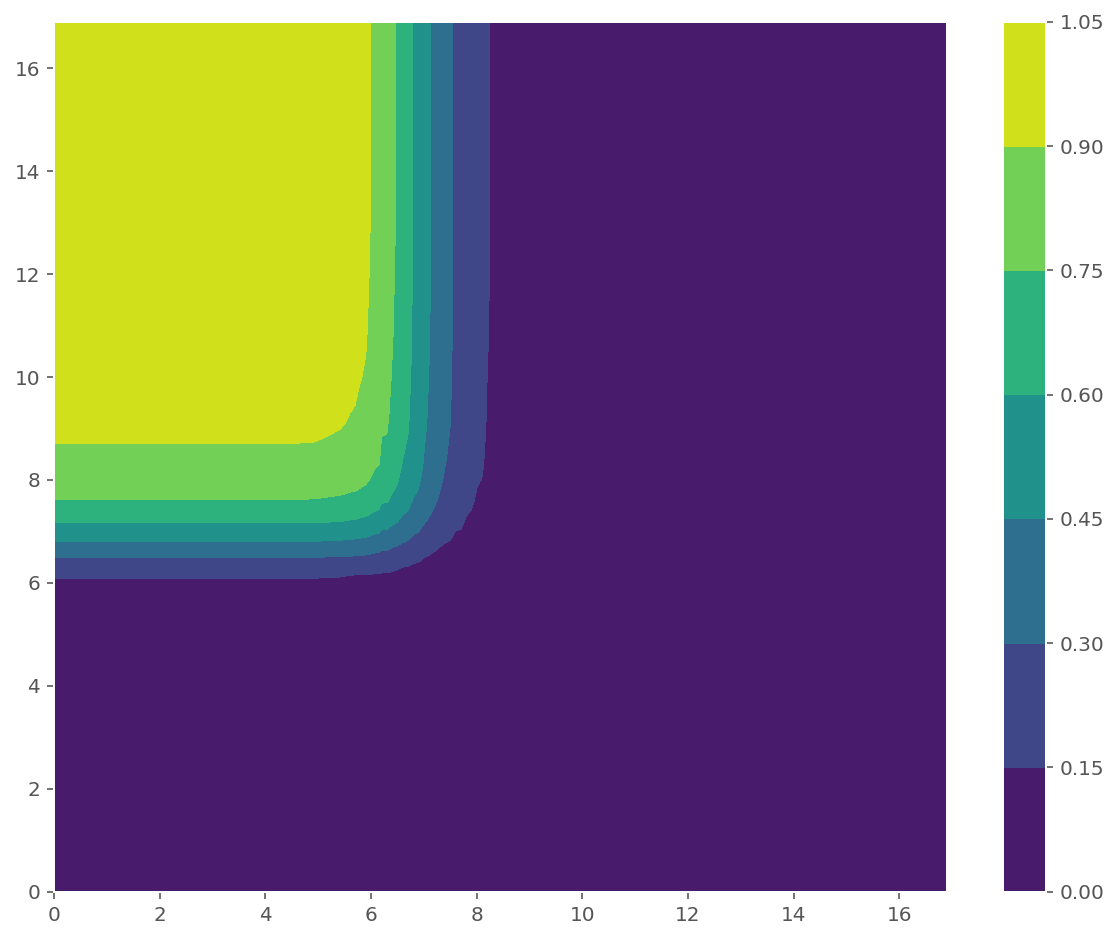

In [12]:
Xshape = len(np.unique(grid[:, 0]))
Yshape = len(np.unique(grid[:, 1]))
X = grid[:, 0].reshape(Xshape, Yshape)
Y = grid[:, 1].reshape(Xshape, Yshape)
Z = pred.reshape(Xshape, Yshape)

fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap='viridis')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # ??
cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()

In [38]:
def show(epochs_list):
    fig = plt.figure(figsize=(20,8))
    for epochs in epochs_list:
        m = LatticeCDF(name, n_row, unique_intervals, pwl_keypoints=None)
        m.fit(train_X,
              train_Y,
              lr=lr,
              bs=bs,
              epochs=epochs,
              loss=args.loss,
              opt=args.opt)
        plt.plot(train_X, m.model.predict(train_X), label=f'{epochs}')
    plt.legend()
    plt.show()

Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
col_0 (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
lattice (Lattice)            (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Train on 38 samples
38/38 [==============================] - 0s 6ms/sample - loss: 0.3512
Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
col_0 (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
lattice (Lattice)            (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
____________________________

Epoch 21/101
38/38 [==============================] - 0s 173us/sample - loss: 0.3320
Epoch 22/101
38/38 [==============================] - 0s 151us/sample - loss: 0.3311
Epoch 23/101
38/38 [==============================] - 0s 171us/sample - loss: 0.3301
Epoch 24/101
38/38 [==============================] - 0s 152us/sample - loss: 0.3292
Epoch 25/101
38/38 [==============================] - 0s 148us/sample - loss: 0.3283
Epoch 26/101
38/38 [==============================] - 0s 166us/sample - loss: 0.3274
Epoch 27/101
38/38 [==============================] - 0s 153us/sample - loss: 0.3265
Epoch 28/101
38/38 [==============================] - 0s 158us/sample - loss: 0.3255
Epoch 29/101
38/38 [==============================] - 0s 137us/sample - loss: 0.3246
Epoch 30/101
38/38 [==============================] - 0s 126us/sample - loss: 0.3237
Epoch 31/101
38/38 [==============================] - 0s 163us/sample - loss: 0.3228
Epoch 32/101
38/38 [==============================] - 0s 136us/sa

Epoch 8/151
38/38 [==============================] - 0s 131us/sample - loss: 0.3444
Epoch 9/151
38/38 [==============================] - 0s 154us/sample - loss: 0.3434
Epoch 10/151
38/38 [==============================] - 0s 131us/sample - loss: 0.3424
Epoch 11/151
38/38 [==============================] - 0s 133us/sample - loss: 0.3415
Epoch 12/151
38/38 [==============================] - 0s 140us/sample - loss: 0.3405
Epoch 13/151
38/38 [==============================] - 0s 134us/sample - loss: 0.3396
Epoch 14/151
38/38 [==============================] - 0s 131us/sample - loss: 0.3386
Epoch 15/151
38/38 [==============================] - 0s 156us/sample - loss: 0.3377
Epoch 16/151
38/38 [==============================] - 0s 131us/sample - loss: 0.3367
Epoch 17/151
38/38 [==============================] - 0s 117us/sample - loss: 0.3358
Epoch 18/151
38/38 [==============================] - 0s 144us/sample - loss: 0.3348
Epoch 19/151
38/38 [==============================] - 0s 131us/samp

Epoch 105/151
38/38 [==============================] - 0s 143us/sample - loss: 0.2632
Epoch 106/151
38/38 [==============================] - 0s 142us/sample - loss: 0.2625
Epoch 107/151
38/38 [==============================] - 0s 146us/sample - loss: 0.2617
Epoch 108/151
38/38 [==============================] - 0s 146us/sample - loss: 0.2610
Epoch 109/151
38/38 [==============================] - 0s 164us/sample - loss: 0.2603
Epoch 110/151
38/38 [==============================] - 0s 139us/sample - loss: 0.2597
Epoch 111/151
38/38 [==============================] - 0s 134us/sample - loss: 0.2590
Epoch 112/151
38/38 [==============================] - 0s 151us/sample - loss: 0.2583
Epoch 113/151
38/38 [==============================] - 0s 134us/sample - loss: 0.2576
Epoch 114/151
38/38 [==============================] - 0s 173us/sample - loss: 0.2569
Epoch 115/151
38/38 [==============================] - 0s 143us/sample - loss: 0.2562
Epoch 116/151
38/38 [==============================] -

Epoch 42/201
38/38 [==============================] - 0s 143us/sample - loss: 0.3130
Epoch 43/201
38/38 [==============================] - 0s 150us/sample - loss: 0.3121
Epoch 44/201
38/38 [==============================] - 0s 141us/sample - loss: 0.3112
Epoch 45/201
38/38 [==============================] - 0s 138us/sample - loss: 0.3104
Epoch 46/201
38/38 [==============================] - 0s 136us/sample - loss: 0.3095
Epoch 47/201
38/38 [==============================] - 0s 133us/sample - loss: 0.3086
Epoch 48/201
38/38 [==============================] - 0s 167us/sample - loss: 0.3078
Epoch 49/201
38/38 [==============================] - 0s 145us/sample - loss: 0.3069
Epoch 50/201
38/38 [==============================] - 0s 130us/sample - loss: 0.3061
Epoch 51/201
38/38 [==============================] - 0s 129us/sample - loss: 0.3052
Epoch 52/201
38/38 [==============================] - 0s 125us/sample - loss: 0.3044
Epoch 53/201
38/38 [==============================] - 0s 137us/sa

Epoch 138/201
38/38 [==============================] - 0s 147us/sample - loss: 0.2411
Epoch 139/201
38/38 [==============================] - 0s 139us/sample - loss: 0.2405
Epoch 140/201
38/38 [==============================] - 0s 161us/sample - loss: 0.2399
Epoch 141/201
38/38 [==============================] - 0s 129us/sample - loss: 0.2393
Epoch 142/201
38/38 [==============================] - 0s 145us/sample - loss: 0.2386
Epoch 143/201
38/38 [==============================] - 0s 160us/sample - loss: 0.2380
Epoch 144/201
38/38 [==============================] - 0s 122us/sample - loss: 0.2374
Epoch 145/201
38/38 [==============================] - 0s 151us/sample - loss: 0.2368
Epoch 146/201
38/38 [==============================] - 0s 173us/sample - loss: 0.2362
Epoch 147/201
38/38 [==============================] - 0s 137us/sample - loss: 0.2356
Epoch 148/201
38/38 [==============================] - 0s 143us/sample - loss: 0.2350
Epoch 149/201
38/38 [==============================] -

Epoch 25/251
38/38 [==============================] - 0s 131us/sample - loss: 0.3283
Epoch 26/251
38/38 [==============================] - 0s 121us/sample - loss: 0.3274
Epoch 27/251
38/38 [==============================] - 0s 145us/sample - loss: 0.3265
Epoch 28/251
38/38 [==============================] - 0s 122us/sample - loss: 0.3255
Epoch 29/251
38/38 [==============================] - 0s 121us/sample - loss: 0.3246
Epoch 30/251
38/38 [==============================] - 0s 154us/sample - loss: 0.3237
Epoch 31/251
38/38 [==============================] - 0s 129us/sample - loss: 0.3228
Epoch 32/251
38/38 [==============================] - 0s 118us/sample - loss: 0.3219
Epoch 33/251
38/38 [==============================] - 0s 131us/sample - loss: 0.3210
Epoch 34/251
38/38 [==============================] - 0s 125us/sample - loss: 0.3201
Epoch 35/251
38/38 [==============================] - 0s 129us/sample - loss: 0.3192
Epoch 36/251
38/38 [==============================] - 0s 146us/sa

38/38 [==============================] - 0s 142us/sample - loss: 0.2521
Epoch 122/251
38/38 [==============================] - 0s 139us/sample - loss: 0.2515
Epoch 123/251
38/38 [==============================] - 0s 146us/sample - loss: 0.2508
Epoch 124/251
38/38 [==============================] - 0s 149us/sample - loss: 0.2502
Epoch 125/251
38/38 [==============================] - 0s 149us/sample - loss: 0.2495
Epoch 126/251
38/38 [==============================] - 0s 126us/sample - loss: 0.2488
Epoch 127/251
38/38 [==============================] - 0s 141us/sample - loss: 0.2482
Epoch 128/251
38/38 [==============================] - 0s 133us/sample - loss: 0.2475
Epoch 129/251
38/38 [==============================] - 0s 142us/sample - loss: 0.2469
Epoch 130/251
38/38 [==============================] - 0s 162us/sample - loss: 0.2462
Epoch 131/251
38/38 [==============================] - 0s 137us/sample - loss: 0.2456
Epoch 132/251
38/38 [==============================] - 0s 140us/samp

Epoch 217/251
38/38 [==============================] - 0s 140us/sample - loss: 0.1984
Epoch 218/251
38/38 [==============================] - 0s 142us/sample - loss: 0.1979
Epoch 219/251
38/38 [==============================] - 0s 153us/sample - loss: 0.1974
Epoch 220/251
38/38 [==============================] - 0s 128us/sample - loss: 0.1970
Epoch 221/251
38/38 [==============================] - 0s 142us/sample - loss: 0.1965
Epoch 222/251
38/38 [==============================] - 0s 129us/sample - loss: 0.1961
Epoch 223/251
38/38 [==============================] - 0s 158us/sample - loss: 0.1956
Epoch 224/251
38/38 [==============================] - 0s 154us/sample - loss: 0.1952
Epoch 225/251
38/38 [==============================] - 0s 131us/sample - loss: 0.1947
Epoch 226/251
38/38 [==============================] - 0s 153us/sample - loss: 0.1943
Epoch 227/251
38/38 [==============================] - 0s 139us/sample - loss: 0.1938
Epoch 228/251
38/38 [==============================] -

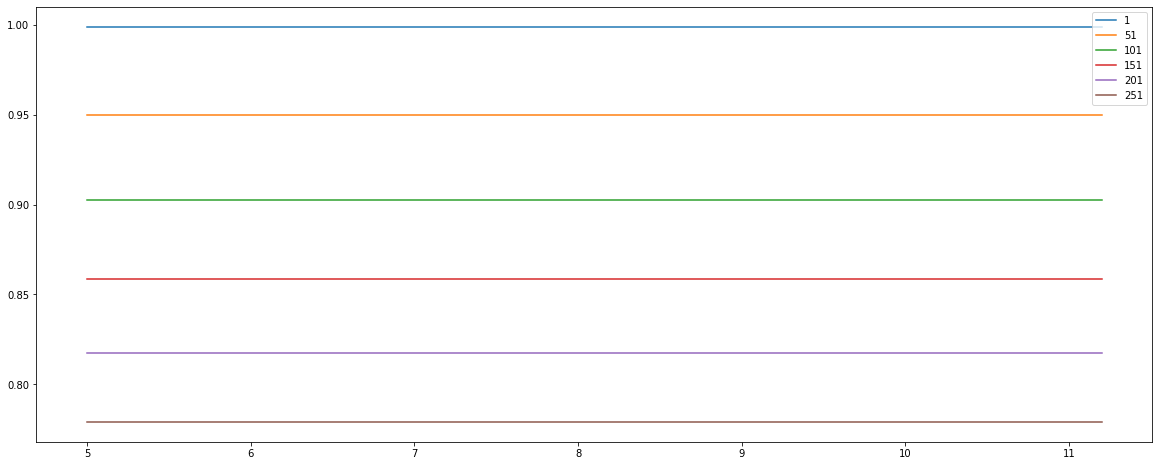

In [39]:
show(range(1, 300, 50))